# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import numpy as np
import pandas as pd

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
bathces = artm.BatchVectorizer(data_path='data.txt', data_format='vowpal_wabbit',
                               target_folder='bathces_data', batch_size=10)

In [5]:
bathces = artm.BatchVectorizer(data_path='bathces_data', data_format='batches')

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [6]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
model = artm.ARTM(num_topics=30, topic_names=['sbj' + str(i) for i in range(T-1)] + ['bcg'],
                  class_ids={'text':1, 'author':1},
                  cache_theta=True, seed=1)
# Ваш код


Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [7]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(bathces.data_path)
model.initialize('dictionary')
# Ваш код


##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [8]:
# Ваш код
model.scores.add(artm.TopTokensScore(name='Word_Tokens', class_id='text',
                                        topic_names=topic_names, num_tokens=15, dictionary=dictionary))

model.scores.add((artm.TopTokensScore(name='Author_Tokens', class_id='author',
                                      topic_names=topic_names, num_tokens=15, dictionary=dictionary)))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [9]:
# Ваш код
tau = 1e5
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='BCG_ADDER',
                                                       tau=tau,
                                                       class_ids=['text'],
                                                       topic_names=['bcg'],
                                                       dictionary=dictionary))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [10]:
# Ваш код
model.fit_offline(batch_vectorizer=bathces, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [11]:
# Ваш код
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='NOT_BCG',
                                                       tau=-tau,
                                                       class_ids=['text'],
                                                       topic_names=['sbj' + str(i) for i in range(T-1)],
                                                       dictionary=dictionary))

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Выполните еще 15 проходов по коллекции.

In [12]:
# Ваш код
model.fit_offline(batch_vectorizer=bathces, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [13]:
# Ваш код
#   Слова

for topic_name in model.topic_names:
    print(topic_name)
    tokens = model.score_tracker["Word_Tokens"].last_tokens
    for word in tokens[topic_name]:
        print(f'{word}', end=' ')
    print('\n')

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sbj0
частица энергия взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя заряд протон масса бозон ускоритель 

sbj1
материал температура структура химический вещество соединение поверхность свойство химия молекула давление углерод сверхпроводимость металл полимер 

sbj2
политический государство власть царь партия церковь народ правитель император средневековый враг сага шмитт государь папа 

sbj3
знание социология социологический познание школа предмет социолог факультет виктор аргумент концепт кафедра логика высказывание прикладной 

sbj4
мозг нейрон мышление предложение категория чтение взрослый синтаксический синтаксис лицо обезьяна детство шимпанзе библиотека игрушка 

sbj5
бог миф греческий герой мифология религия душа ритуал грек море мифологический гусейнов божество культ шумерский 

sbj6
русский слово текст словарь перевод корпус гласный согласный говор немецкий древнерусский академия цитата произносить издание 

sbj7
раса трудность африка праздник ш

In [14]:
#   Авторы
for topic_name in model.topic_names:
    print(topic_name)
    tokens = model.score_tracker['Author_Tokens'].last_tokens
    for word in tokens[topic_name]:
        print(f'{word}', end=' ')
    print('\n')

sbj0
Дмитрий_Казаков Михаил_Данилов Виктор_Брагута Павел_Пахлов Сергей_Майоров Лев_Дудко Сергей_Троицкий Эдуард_Боос Анатолий_Лиходед Лев_Беклемишев Игорь_Волобуев Валерий_Рубаков Жан-Арыс_Джилкибаев Дэвид_Гросс Дмитрий_Харзеев 

sbj1
Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Евгений_Гудилин Иван_Сорокин Владимир_Пудалов Дмитрий_Гольберг Валентин_Крапошин Пётр_Образцов Вадим_Бражкин Алексей_Хохлов Сергей_Морозов Дмитрий_Клинов Владимир_Комлев 

sbj2
Александр_Марей Кирилл_Мартынов Алексей_Юдин Михаил_Бойцов Александр_Павлов Фёдор_Успенский Иван_Ладынин Дина_Гусейнова Рафаэль_Арутюнян Ольга_Тогоева Александр_Воеводский Юрий_Рогулёв Владимир_Малахов Владимир_Петрухин Руслан_Хестанов 

sbj3
Виктор_Вахштайн Андрей_Лукашов Максим_Демин Татьяна_Клячко Борис_Миркин Алексей_Котов Дмитрий_Балалыкин Сергей_Зенкин Татьяна_Котова Максим_Кронгауз Владимир_Миронов Ян_Левченко Алексей_Рубцов Александр_Филиппов Михаил_Маяцкий 

sbj4
Филипп_Хайтович Владимир_Спиридонов Александр_К

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [15]:
theme = ['Физика частиц', 'Физика материалов', 'Церковь как аппарат государcтсва',
         'Социология', 'Нейронные связи в мозге', 'Греческая мифология',
         'Русский язык', 'Африканские расы', 'Юридическое право',
         'Медицина', 'Строение организмов', 'Психология памяти',
         'Древние университеты', 'Городское строение общества',
         'Космические исследования', 'Экономика', 'Семья', 'Программирование',
         'Восточное государство', 'ДНК', 'Квантовая физика', 'Философия',
         'Французская революция', 'Революция в Российской Империи', 'Христианство',
         'Математика', 'Театр', 'Астрономия', 'Кино']
sbj_topic_labels = theme   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [16]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id
# Ваш код
matrix_phi = model.get_phi(class_ids=['author'])
matrix_theta = model.get_theta()

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

<AxesSubplot:>

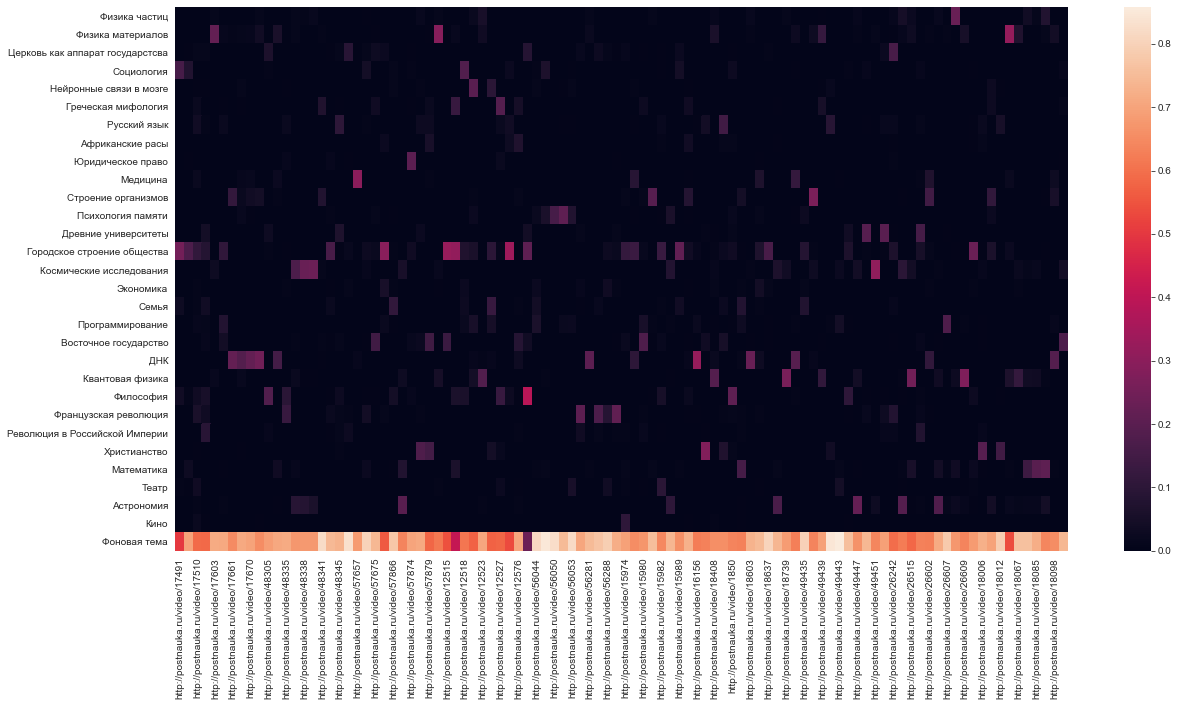

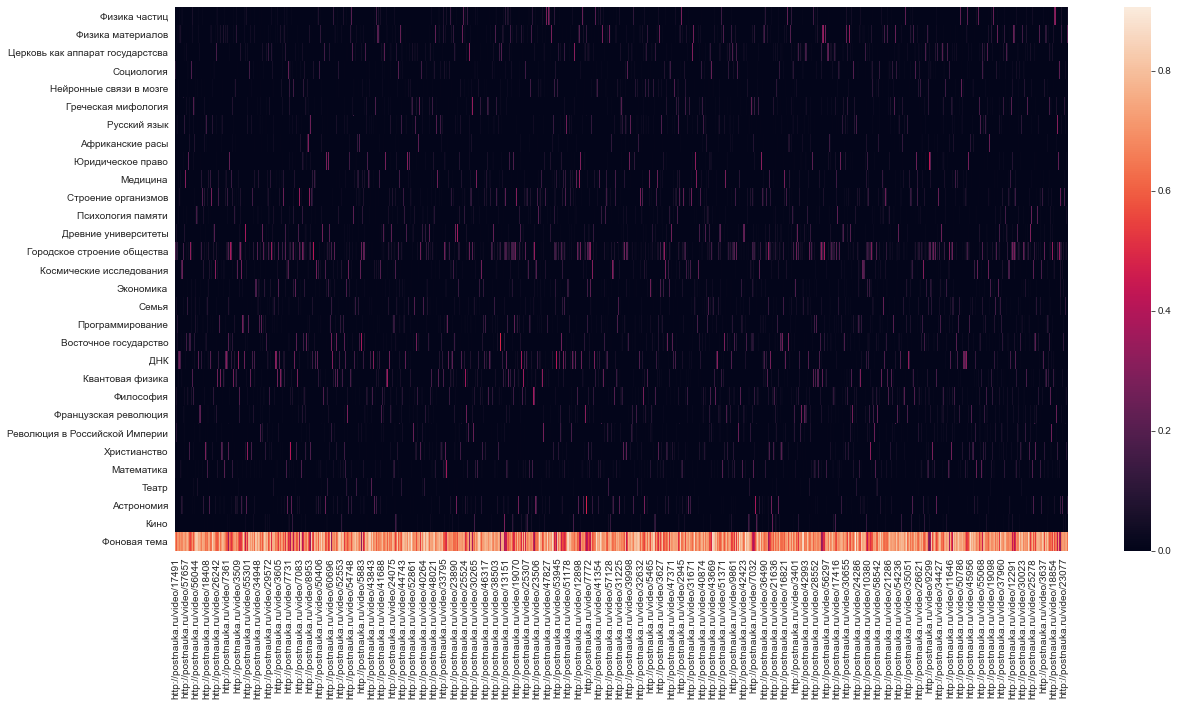

In [17]:
matrix_theta.index = topic_labels
figure = plt.figure(figsize=(20,10))
ax = plt.axes()
seaborn.heatmap(matrix_theta.iloc[:, :100])

figure = plt.figure(figsize=(20,10))
ax = plt.axes()
seaborn.heatmap(matrix_theta.iloc[:, :])
# Ваш код


Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [18]:
# Ваш код
themes = []
for i in range(matrix_theta.shape[0]):
    buf = sum(matrix_theta.iloc[i,:]) / matrix_theta.shape[1]
    themes.append(buf)

In [19]:
dataframe = pd.DataFrame(index=topic_labels)
dataframe['Вероятность'] = themes

In [20]:
print('Сумма вероятностей', sum(dataframe['Вероятность']))
# Видимо набегает какая-то ошибка

Сумма вероятностей 1.0000000035110927


In [21]:
zipped = list(zip(themes, topic_labels))
print(list(zipped))
sorted_array = sorted(zipped, key=lambda x: x[0])

[(0.010021673009517297, 'Физика частиц'), (0.01331199772128065, 'Физика материалов'), (0.01088767946892298, 'Церковь как аппарат государcтсва'), (0.007176382089689566, 'Социология'), (0.006058908396273886, 'Нейронные связи в мозге'), (0.008135534976111492, 'Греческая мифология'), (0.0076180794607912435, 'Русский язык'), (0.004779412007494121, 'Африканские расы'), (0.007440966645117443, 'Юридическое право'), (0.01126459392522702, 'Медицина'), (0.014469198387824126, 'Строение организмов'), (0.006377918828349673, 'Психология памяти'), (0.009873784680642081, 'Древние университеты'), (0.041786555798297875, 'Городское строение общества'), (0.011454378838250782, 'Космические исследования'), (0.009198170015802127, 'Экономика'), (0.008119517306027375, 'Семья'), (0.009913362469895793, 'Программирование'), (0.013185393818479541, 'Восточное государство'), (0.021650906072345103, 'ДНК'), (0.015673364227624383, 'Квантовая физика'), (0.014533821896946506, 'Философия'), (0.008877374683065712, 'Французс

In [22]:
sorted_array

[(0.0029578181210897403, 'Театр'),
 (0.004779412007494121, 'Африканские расы'),
 (0.005715177219806781, 'Кино'),
 (0.006058908396273886, 'Нейронные связи в мозге'),
 (0.006377918828349673, 'Психология памяти'),
 (0.0070646017884490354, 'Революция в Российской Империи'),
 (0.007176382089689566, 'Социология'),
 (0.007440966645117443, 'Юридическое право'),
 (0.0076180794607912435, 'Русский язык'),
 (0.008119517306027375, 'Семья'),
 (0.008135534976111492, 'Греческая мифология'),
 (0.008877374683065712, 'Французская революция'),
 (0.009198170015802127, 'Экономика'),
 (0.009220242032690267, 'Математика'),
 (0.009873784680642081, 'Древние университеты'),
 (0.009913362469895793, 'Программирование'),
 (0.010021673009517297, 'Физика частиц'),
 (0.01088767946892298, 'Церковь как аппарат государcтсва'),
 (0.01126459392522702, 'Медицина'),
 (0.011454378838250782, 'Космические исследования'),
 (0.011510083541461968, 'Астрономия'),
 (0.013185393818479541, 'Восточное государство'),
 (0.013265354851591

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [23]:
max_array = sorted_array[-5:]
min_array = sorted_array[:3]
print('MAX', '\n', max_array)
print('MIN', '\n', min_array)

MAX 
 [(0.014533821896946506, 'Философия'), (0.015673364227624383, 'Квантовая физика'), (0.021650906072345103, 'ДНК'), (0.041786555798297875, 'Городское строение общества'), (0.6784577512320269, 'Фоновая тема')]
MIN 
 [(0.0029578181210897403, 'Театр'), (0.004779412007494121, 'Африканские расы'), (0.005715177219806781, 'Кино')]


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

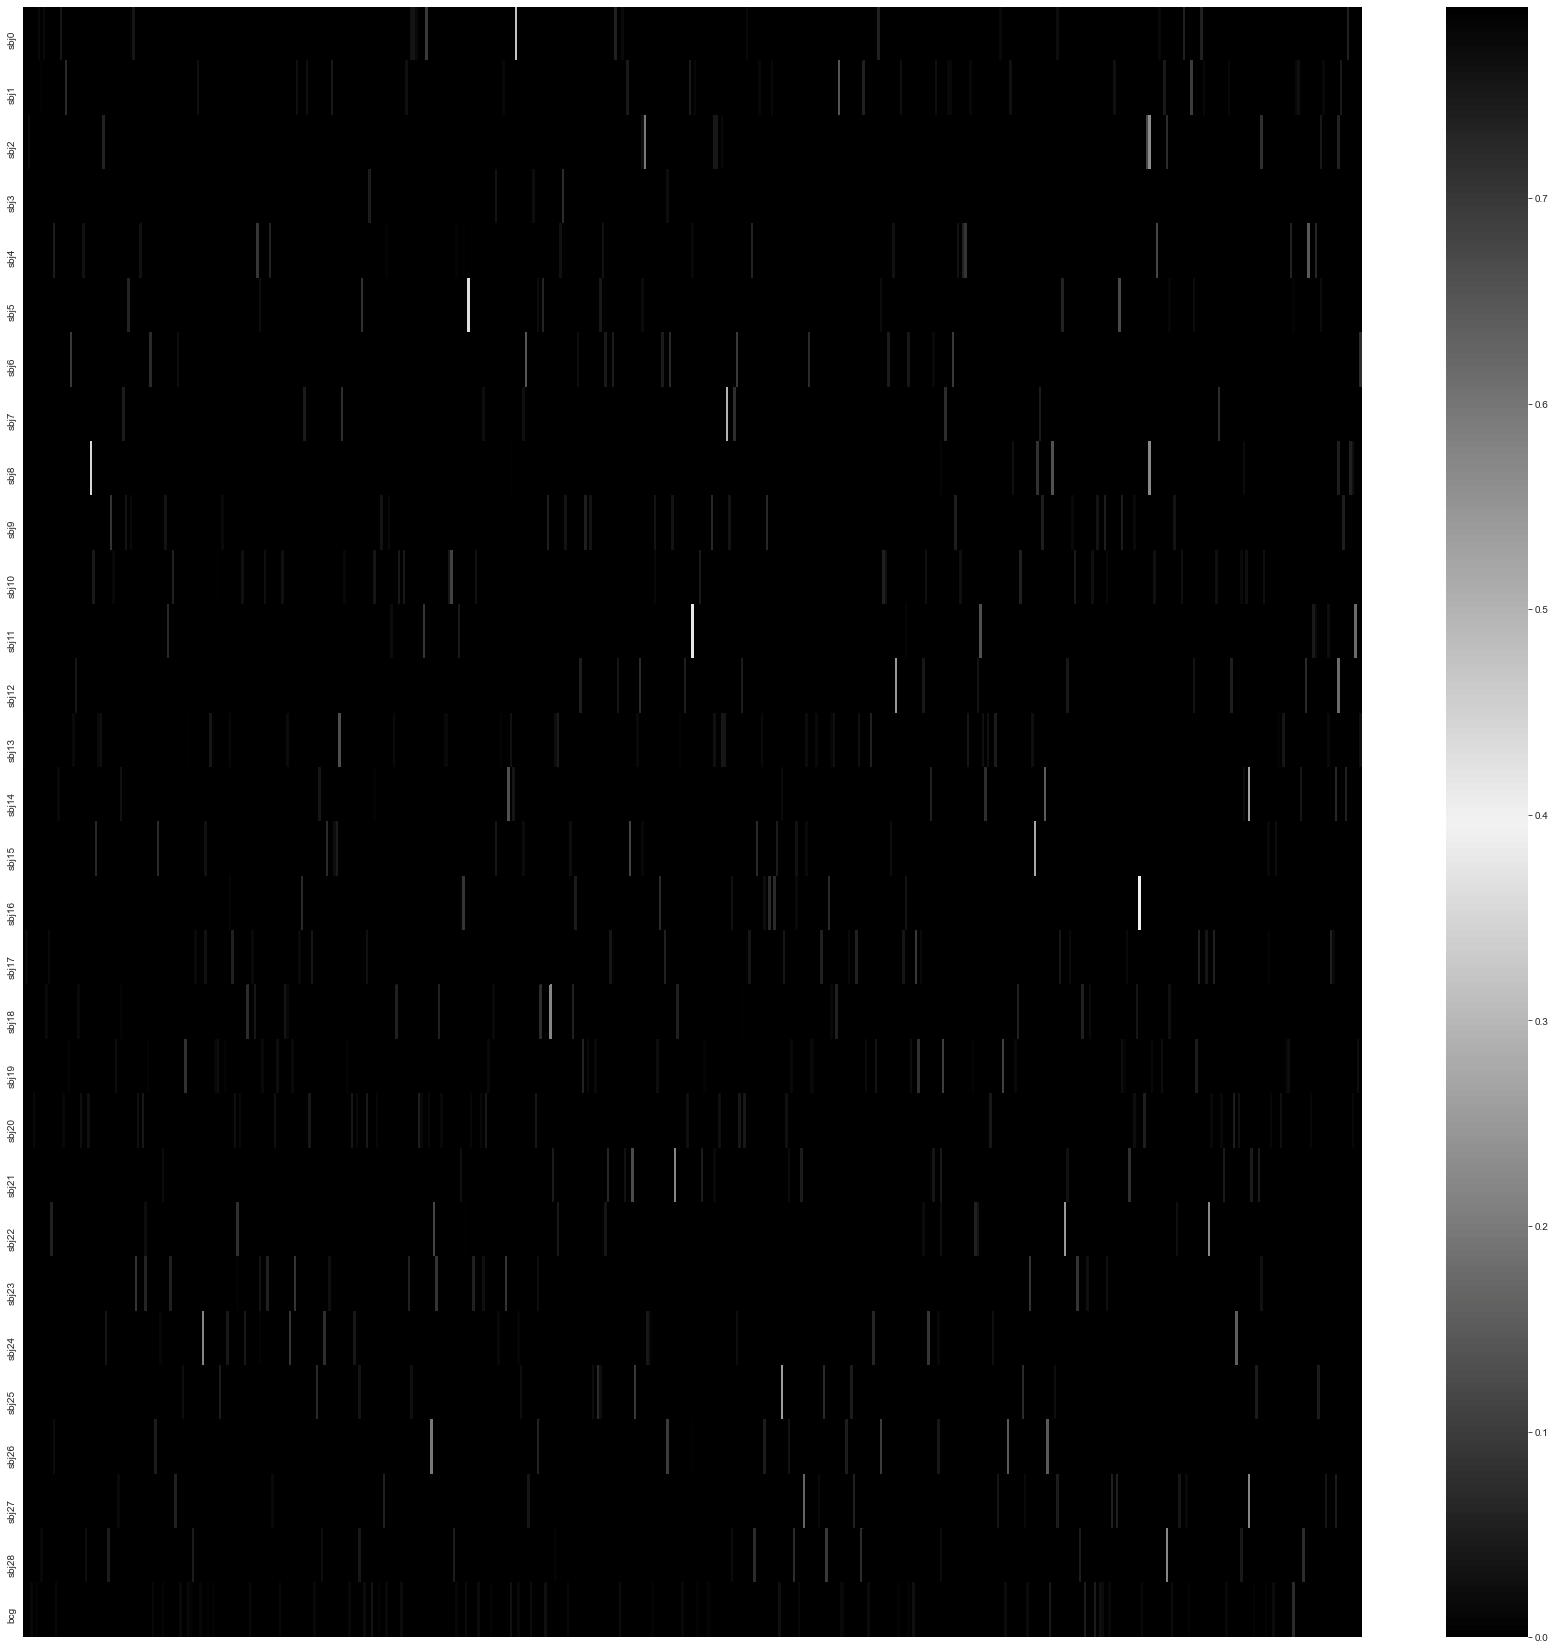

In [24]:
# Ваш код
plt.figure(figsize=(30,30))
cmap = seaborn.diverging_palette(250,15, 75, 0, n=500, center='light')
seaborn.heatmap(matrix_phi.T, xticklabels=False, cmap=cmap)
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [25]:
hold = .01
for _ in range(matrix_phi.shape[0]):
    if np.sum(sum([matrix_phi.iloc[_,:] > hold])) >= 3:
        print('AUTHOR:', list(matrix_phi.index[_])[1])

AUTHOR: Андрей_Журавлев
AUTHOR: Александр_Воеводский
AUTHOR: Дина_Гусейнова
AUTHOR: Ольга_Вайнштейн
AUTHOR: Фёдор_Успенский


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [26]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
import matplotlib.cm as cm

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

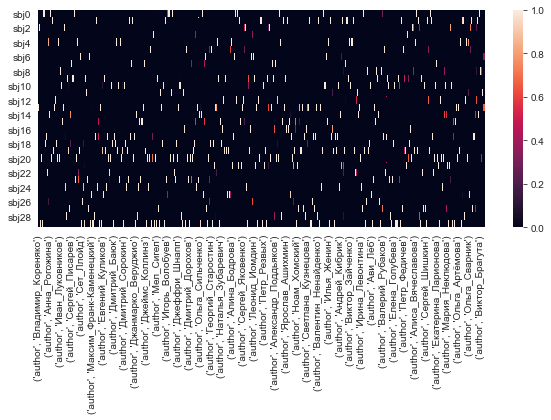

In [28]:
# Ваш код
p_t = dataframe['Вероятность'].to_numpy()
p_ta = matrix_phi.T
for arrow in range(p_ta.shape[0]):
    p_ta.values[arrow,:] *= p_t[arrow]
for arrow in range(p_ta.shape[1]):
    p_ta.values[:, arrow] /= sum(p_ta.values[:, arrow])

plt.figure(figsize=(10,4))
seaborn.heatmap(p_ta)

In [29]:
precomputed = pairwise_distances(p_ta.T, metric='cosine')

mds_model = MDS(n_components=2, dissimilarity='precomputed')
mds_transformed_cosine = mds_model.fit_transform(precomputed)

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


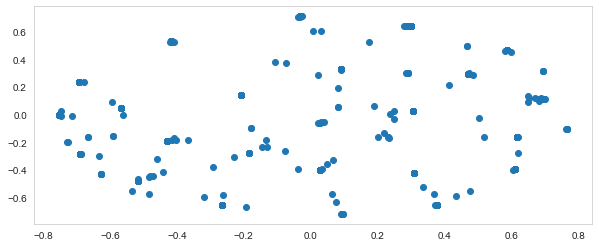

In [30]:
plt.figure(figsize=(10,4))
plt.scatter(mds_transformed_cosine[:,0], mds_transformed_cosine[:,1])

Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [31]:
# Ваш код


Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [32]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
p_ta_copy = p_ta
p_ta_copy.index = topic_labels
p_ta_copy.columns = [author[1] for author in p_ta.columns]

In [33]:
authors_themes_dict = []
uniq_max_themes = []
for j in range(p_ta_copy.shape[1]):
#    print(p_ta_copy.columns[j])
    max_theme = p_ta_copy.index[p_ta_copy.values[:,j] == np.max(p_ta_copy.values[:,j])]
    authors_themes_dict.append([p_ta_copy.columns[j], max_theme.values[0]])
    if not max_theme in uniq_max_themes:
        uniq_max_themes.append(max_theme.values[0])
print(uniq_max_themes)

['Городское строение общества', 'Программирование', 'Церковь как аппарат государcтсва', 'Фоновая тема', 'Квантовая физика', 'Физика частиц', 'Кино', 'Восточное государство', 'Французская революция', 'Нейронные связи в мозге', 'Космические исследования', 'Физика материалов', 'ДНК', 'Русский язык', 'Древние университеты', 'Юридическое право', 'Строение организмов', 'Экономика', 'Христианство', 'Медицина', 'Астрономия', 'Африканские расы', 'Греческая мифология', 'Революция в Российской Империи', 'Театр', 'Психология памяти', 'Математика', 'Семья', 'Социология', 'Философия']


In [34]:
#    uniq_max_themes show how many color markers we need to have
colors = cm.rainbow(np.linspace(0,1, len(uniq_max_themes)))
colors_data = list(zip(colors, uniq_max_themes))

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


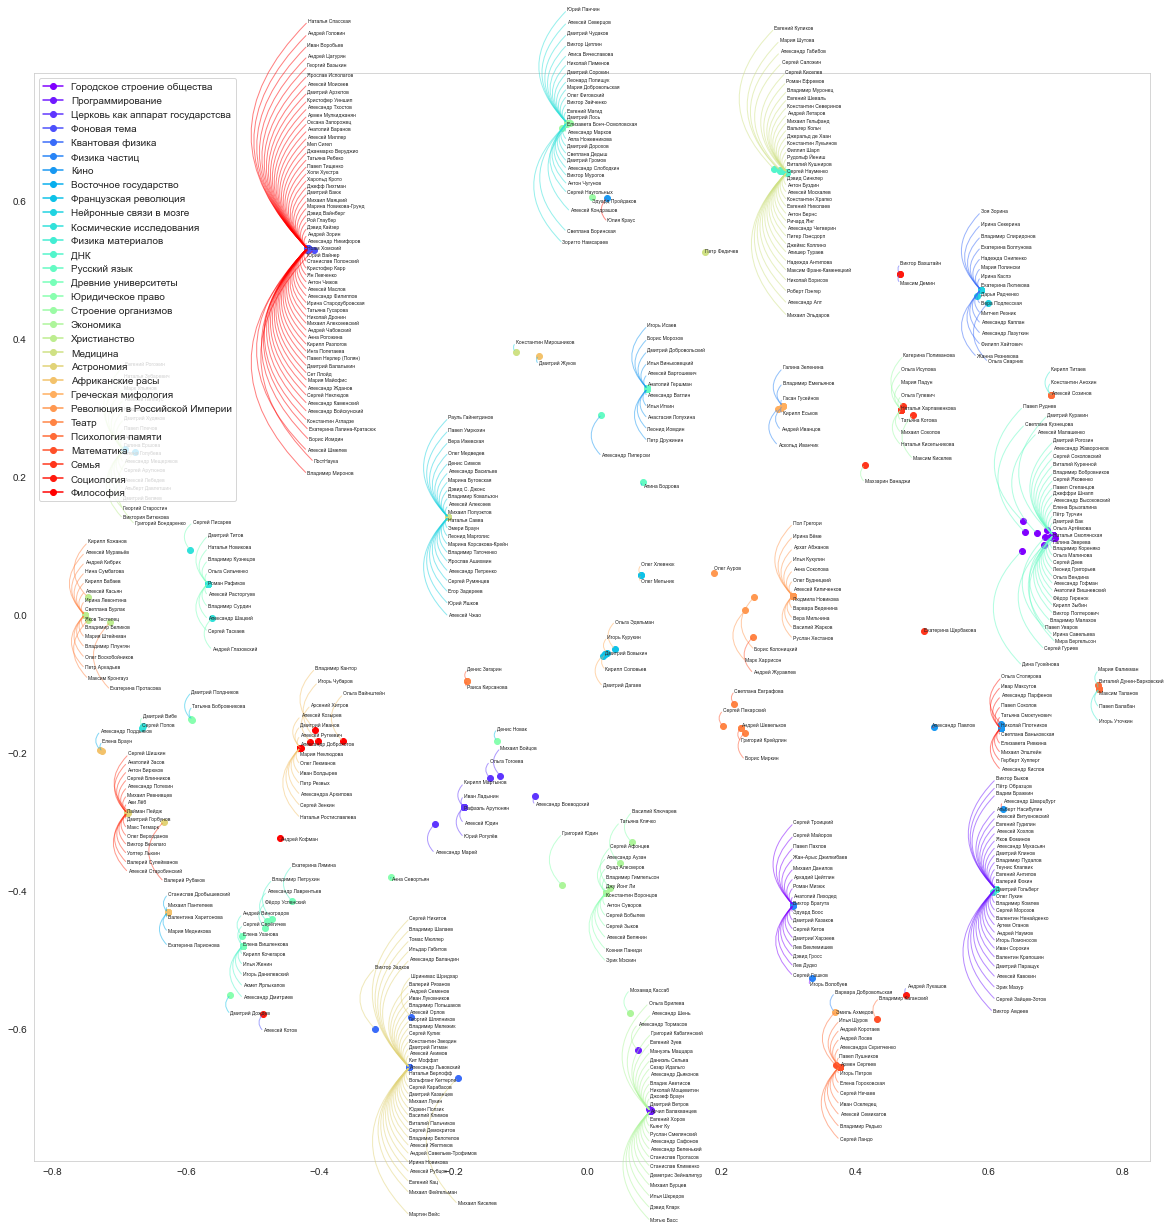

In [106]:
plt.figure(figsize=(20,20))
#plt.scatter(mds_transformed_cosine[:,0], mds_transformed_cosine[:,1], cmap=)
authors = p_ta.columns
for i in range(mds_transformed_cosine.shape[0]):
    input_str = authors_themes_dict[i][1]
    for ii in range(len(colors_data)):
        if colors_data[ii][1] == input_str:
            color = colors_data[ii][0]
    plt.scatter(mds_transformed_cosine[i,0], mds_transformed_cosine[i,1], color=color)
    #   Создается наложение
    #plt.annotate(text=str(authors_themes_dict[i][0]).replace('_', ' '), xy=(mds_transformed_cosine[i,0], mds_transformed_cosine[i,1]))
legend = []
#   Очень хорошее решение со стрелками
X = mds_transformed_cosine
aspect = 20   # Соотношение ширины надписи к высоте
max_d  = 1e-1 # Расстояние столкновения
v      = 5e-1 # Скорость раздвигания
max_k  = 3    # Число итераций
X_ = X.copy()
for k in range(max_k):
    V = np.zeros_like(X_)
    for i in range(1,X_.shape[0]):
        for j in range(i):
            d = X_[i,:]-X_[j,:]
            if (abs(d)<np.array([aspect,1])*max_d).all():
                s = np.sign(d)
                s += (s==0)
                s *= np.array([aspect,1])*max_d
                s *= np.max((max_d-abs(d),np.zeros_like(d)),axis=0)
                if abs(s[0])<abs(s[1]):
                    V[i,0] += s[0]
                    V[j,0] -= s[0]
                else:
                    V[i,1] += s[1]
                    V[j,1] -= s[1]
    X_ += V*v
    if ~V.any(): break
    #print(k,end=' ')
    #v *= 0.8
c = [colors[p_ta.values[:,i].argmax()] for i in range(p_ta.shape[1])]
for i,author in enumerate(matrix_phi.index):
    x  = X [i,:]
    x_ = X_[i,:]
    if not (x==x_).all():
        if x_[1]>x[1]:
            connectionstyle = 'arc3,rad=0.5'
        else:
            connectionstyle = 'arc3,rad=-0.5'

        plt.annotate('',xy=x,xytext=x_,arrowprops = {'arrowstyle': '-','color':c[i],'alpha':.5,'connectionstyle':connectionstyle})

#Нанесение надписей
for i,author in enumerate(matrix_phi.index):
    x  = X [i,:]
    x_ = X_[i,:]
    if (x==x_).all():
        plt.annotate(author[1].replace('_',' '),x,   fontsize=5)
    else:
        plt.annotate(author[1].replace('_',' '),x,x_,fontsize=5)


#   Cjздание легенты
for i in range(len(colors_data)):
    legend.append(plt.Line2D([],[], linestyle=None, marker='o', color=colors_data[i][0], label=str(colors_data[i][1])))
plt.legend(handles = legend, loc='upper left')

plt.savefig('graphic.pdf', format='pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [37]:
authors_themes = p_ta.columns
# Ваш код
authors_themes.columns = [name[1] for name in p_ta.columns]

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [42]:
print(u"http://yandex.ru")  # получится кликабельная ссылка

http://yandex.ru


/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [39]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [93]:
dt_inds = np.argsort(matrix_theta.values,axis=1)[:,::-1]
print(dt_inds)
matrix_theta
matrix_theta.loc['Физика частиц', :].sort_values(axis=0, ascending=False)[:10].index
matrix_theta

[[ 786 1703 1704 ...  429 1074    0]
 [1255 1306   93 ...  839  817    0]
 [ 570  773 1002 ...  876  874    0]
 ...
 [ 797  871 1124 ...  910  905    0]
 [ 743 1463  638 ...  965  966    0]
 [1317  952 1104 ... 1460  801   39]]


/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,http://postnauka.ru/video/17491,http://postnauka.ru/video/17492,http://postnauka.ru/video/17510,http://postnauka.ru/video/17602,http://postnauka.ru/video/17603,http://postnauka.ru/video/17604,http://postnauka.ru/video/17661,http://postnauka.ru/video/17666,http://postnauka.ru/video/17670,http://postnauka.ru/video/17673,...,http://postnauka.ru/video/22977,http://postnauka.ru/video/22978,http://postnauka.ru/video/23077,http://postnauka.ru/video/23079,http://postnauka.ru/video/23111,http://postnauka.ru/video/23161,http://postnauka.ru/video/23163,http://postnauka.ru/video/23172,http://postnauka.ru/video/23233,http://postnauka.ru/video/23253
Физика частиц,0.000000e+00,0.000000e+00,6.998397e-12,0.000000e+00,1.307371e-02,0.000000e+00,0.000000e+00,4.930202e-06,3.737034e-05,1.088053e-02,...,3.624822e-12,0.000000e+00,7.431879e-06,0.000000e+00,0.000000e+00,1.972359e-11,0.000000e+00,0.000000e+00,0.000000e+00,4.727678e-02
Физика материалов,0.000000e+00,0.000000e+00,0.000000e+00,7.094962e-12,2.195263e-01,1.663917e-02,9.025650e-03,1.222242e-02,1.416746e-02,3.800250e-02,...,7.625380e-03,0.000000e+00,3.526795e-15,0.000000e+00,1.355216e-02,7.290251e-07,4.758749e-10,0.000000e+00,3.064867e-08,2.027144e-01
Церковь как аппарат государcтсва,0.000000e+00,3.959356e-03,1.089450e-02,1.336151e-02,1.254722e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.416254e-02,2.778926e-03,0.000000e+00,4.383706e-03,3.157111e-02,6.883236e-08,1.483477e-15,2.142207e-05,0.000000e+00
Социология,1.592471e-01,7.556612e-02,4.779291e-10,0.000000e+00,2.757522e-11,2.118947e-04,9.350605e-11,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,8.793476e-07,2.283251e-06,2.360166e-02,0.000000e+00,0.000000e+00,2.972466e-02,3.735250e-15,0.000000e+00,1.333854e-04
Нейронные связи в мозге,0.000000e+00,0.000000e+00,4.593955e-03,5.012366e-03,0.000000e+00,5.960336e-10,2.303930e-09,1.081036e-02,1.319214e-03,0.000000e+00,...,5.078364e-14,0.000000e+00,0.000000e+00,1.239533e-02,0.000000e+00,0.000000e+00,2.681408e-05,6.169169e-03,1.319643e-02,0.000000e+00
Греческая мифология,0.000000e+00,1.258231e-15,2.279508e-02,6.478196e-04,0.000000e+00,5.122071e-03,0.000000e+00,5.470742e-03,6.410318e-08,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.413675e-02,0.000000e+00,1.289216e-02,0.000000e+00,3.629897e-03,1.106579e-12
Русский язык,0.000000e+00,0.000000e+00,3.789138e-02,9.275752e-03,5.551180e-08,2.172221e-02,0.000000e+00,0.000000e+00,1.706657e-10,0.000000e+00,...,1.264526e-06,2.800875e-03,0.000000e+00,2.439839e-03,0.000000e+00,4.323131e-02,1.806585e-02,0.000000e+00,3.800242e-03,0.000000e+00
Африканские расы,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.641715e-13,0.000000e+00,2.201318e-14,5.782901e-14,0.000000e+00,0.000000e+00,...,6.442544e-07,0.000000e+00,1.307780e-05,0.000000e+00,5.234984e-03,0.000000e+00,1.054701e-06,0.000000e+00,8.506979e-11,0.000000e+00
Юридическое право,1.259642e-07,3.856973e-03,1.012488e-04,0.000000e+00,4.424580e-08,1.363465e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.368459e-09,4.700548e-03,1.323771e-02,2.408994e-10,0.000000e+00,0.000000e+00,1.367680e-11,2.051858e-02,0.000000e+00
Медицина,0.000000e+00,6.568227e-04,2.303920e-02,0.000000e+00,1.038975e-11,0.000000e+00,4.855107e-04,1.459066e-02,1.856559e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.552316e-02,0.000000e+00,7.392713e-06,9.534012e-02,0.000000e+00,1.082565e-11


In [105]:
# Ваш код
max_documents = 10

for counter, input_zip in enumerate(zip(topic_names, sbj_topic_labels)):
    theme_name = input_zip[0]
    theme_name_technical = input_zip[1]
    display(HTML(u"<h3>"+sbj_topic_labels[counter]+"</h3>"))
    display(HTML(u"Ключевые слова: <font color = 'green'>" + ', '.join(
        model.score_tracker['Word_Tokens'].last_tokens[theme_name])
                 + '</font>'))
    display(HTML(u"Релевантные документы:"))
    hrefs = matrix_theta.loc[theme_name_technical, :].sort_values(axis=0, ascending=False)[:max_documents].index
    urls = []
    for arrow in range(max_documents):
        urls.append('<a href="'+hrefs[arrow]+'">'+str(arrow)+'</a>')
    display(HTML(u"<font color='red'>" + ", ".join(urls) + u"</font>"))
#model.score_tracker['Word_Tokens'].last_tokens

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 